# Using SQLite to answer Business Questions

In this project, we'll use R and SQL to answer a variety of critical business questions for a company, pertaining to:

### 1. **Determining Genre Popularity**

Knowing which genres are more popular, helps us stock our stores better with tracks and albums that will appeal to more people.

### 2. **Employee Performance**

We want to identify if any one Employee performs better or worse than another, based on the sales revenue generated by the clients served by that employee.

### 3. **Customer-base and Sales Revenue by Country**

We also want to gain a clearer understanding of which country contributes the most to our revenue, and which countries that currently occupy a smaller share of our market might hold potential for future growth.

### 4. **Customer Purchase Behavior**

Information on customer purchase behaviours will allow us to make better decisions that minimize overhead costs and maximize our revenue by tailoring our existing market precisely to the purchase behaviors of our clients.

The database we'll be working with here is the `chinook.db` file from the [Chinook Database](https://github.com/lerocha/chinook-database). The database can be downloaded [here](https://dsserver-prod-resources-1.s3.amazonaws.com/374/chinook.db).

To start with, we'll import some of the necessary libraries:

In [1]:
library(RSQLite)
library(DBI)

Warning message:
"package 'RSQLite' was built under R version 3.6.1"

## Introduction

We'll begin by defining a helper function, `run_query()`, that takes in a query and returns the result, and also connects and disconnects to the database automatically.

In [2]:
run_query <- function(q){
    conn <- dbConnect(SQLite(), "chinook.db")
    result <- dbGetQuery(conn, q)
    dbDisconnect(conn)
    return(result)
}

We'll also create a `show_tables()` function that calls the `run_query()` function to return a list of all tables and views in the database. This will be helpful to us in keeping track of the existing tables, as well as any views we create.

In [3]:
show_tables <- function(){
    run_query("
    SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ('table','view');")
}

show_tables()

name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


## Determining which genre has the largest Customer Base in the USA

The situation we're facing is that the Chinook record store has just signed a deal with a new record label, and we're in charge of choosing the first three albums to be added to the store. There are four albums to choose from, and all four are by artists who don't have any tracks in the store right now. Below is the list of artist names and the genre of music they produce:

- Regal - Hip Hop
- Red Tone - Punk
- Meteor and the Girls - Pop
- Slim Jim Bites - Blues

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA. To aid in selecting albums, we're interested in finding out which genres sell the best in the USA.

**We'll need to write a query to find out which genres have the most customers in the USA**. Once we have the results of the query on hand, we can experiment with different visualization methods in `ggplot2`. We're trying to establish comparisons between genres, so the best visualizations will allow a user to instantly see differences between them.

The query we write will thus return:

1) The genre.

2) The absolute number of customers of that genre.

3) The amount of customers as a percentage.

### Writing the Query

In [4]:
customer_genres <- "
WITH table1 AS (
SELECT 
    t.track_id, 
    g.name, 
    t.genre_id, 
    il.invoice_id, 
    i.customer_id 
FROM track t
LEFT JOIN genre g ON g.genre_id = t.genre_id
LEFT JOIN invoice_line il ON il.track_id = t.track_id
LEFT JOIN invoice i ON i.invoice_id = il.invoice_id)

SELECT 
    name Genre, 
    COUNT(customer_id) Customers 
FROM table1
GROUP BY name
ORDER BY 2 DESC
"

run_query(customer_genres)

Genre,Customers
Rock,2635
Metal,619
Alternative & Punk,492
Latin,167
R&B/Soul,159
Blues,124
Jazz,121
Alternative,117
Easy Listening,74
Pop,63


The above query returns each Genre, and the number of unique customers of that genre. We have the information we need from the table above to create the 3rd column we want - the percentage of each genre sold. 

We'll just have to slightly re-write the query to include that 3rd column.

In [5]:
genre_sales <- run_query("
WITH table1 AS (
SELECT 
    t.track_id, 
    g.name, 
    t.genre_id, 
    il.invoice_id, 
    i.customer_id 
FROM track t
LEFT JOIN genre g ON g.genre_id = t.genre_id
LEFT JOIN invoice_line il ON il.track_id = t.track_id
LEFT JOIN invoice i ON i.invoice_id = il.invoice_id
LEFT JOIN customer c ON c.customer_id = i.customer_id
WHERE c.country = 'USA'),

table2 AS ( 
SELECT
    name Genre, 
    COUNT(customer_id) Customers 
FROM table1
GROUP BY name
ORDER BY 2 DESC
LIMIT 9)

SELECT 
    Genre, 
    Customers, 
    (CAST(Customers as FLOAT)/CAST((SELECT SUM(Customers) FROM table2) AS FLOAT) * 100) Percent 
FROM table2
")

genre_sales

Genre,Customers,Percent
Rock,561,55.932203
Alternative & Punk,130,12.961117
Metal,124,12.362911
R&B/Soul,53,5.284148
Blues,36,3.589232
Alternative,35,3.489531
Latin,22,2.193420
Pop,22,2.193420
Hip Hop/Rap,20,1.994018


We have above the table with the information we need. Let's now import some further libraries to help us visualize and analyze the table.

### Visualizing the Genre sales Data

In [6]:
library(tidyverse)
library(ggplot2)
library(dplyr)

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.2.0     v purrr   0.3.2
v tibble  2.1.3     v dplyr   0.8.3
v tidyr   0.8.3     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0
Warning message:
"package 'dplyr' was built under R version 3.6.1"-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


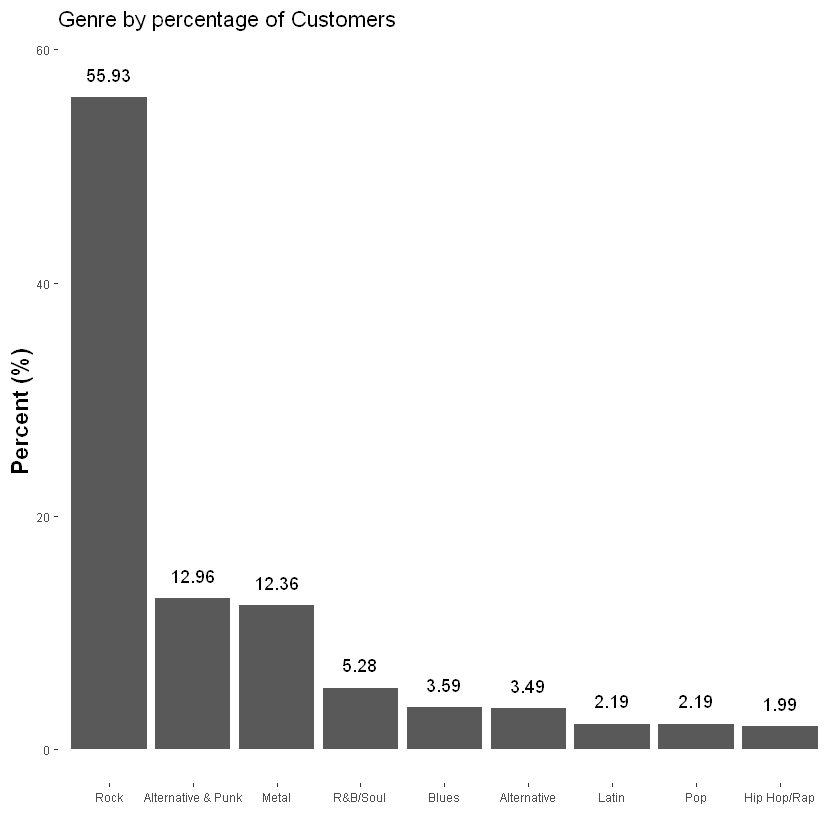

In [7]:
(ggplot(data=genre_sales)
 + aes(x=reorder(Genre, -Percent), y = Percent) + geom_bar(stat="identity") 
 + labs(title="Genre by percentage of Customers", x="", y = "Percent (%)")
 + theme(axis.text=element_text(size=7),
        axis.title=element_text(size=14,face="bold"), panel.background = element_rect(fill="white")) 
 + geom_text(aes(Genre, Percent + 2, label = round(Percent, 2) , fill = NULL), data = genre_sales))

We see that Rock has the biggest customer base by a staggering margin - coming out on top with almost 56% of all customers. The next most popular 2 genres are 'Alternative Punk' and 'Metal' in that order, both with around a 13% share of the customers. 

**It should be noted that 'Alternative Punk', 'Metal' and 'Rock' account for almost 82% of all customers between the 3 of them, and the 'Rock' genre alone accounts for about 57% of them**.

Looking more specifically at the genres of interest, in descending order of customer-base::


- Punk: 12.95%
- Blues: 3.59%
- Pop: 2.19%
- Hip Hop: 1.99%

We can thus conclude that the first 3 albums to be added to the store should be:

1. Red Tone (Punk Genre)
2. Slim Jim Bites (Blues Genre)
3. Meteor and the Girls (Pop Genre)

Of these, Red Tone is likely to sell the most. 

Although we're forgoing the 'Regal' album (Hip Hop Genre) it should be noted that had we chosen it, 'Regal' would have probably sold a very similar amount of albums to 'Meteor and the Girls', because the 'Hip Hop' and 'Pop' genres hold a similar share of the customer-base, at 1.99% and 2.19% respectively. 

**Because of the overwhelming popularity of the 'Rock' genre, it would also be very well-advised to ask the record label if they have any Rock albums arriving soon**.

## Analysis of Sales Support Agent Performance

Each customer in the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. We have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

Because it's very likely that performance probably correlates to an extent with the length of time an employee has been in service, we should also carefully monitor each employee's length of employment.

The primary metric we'll look at is the 'Total' amount of sales generated by all the customers for whom the employee is the Sales Support Agent.

### Constructing the Query

In [8]:
employee_query = "

WITH table1 AS (
SELECT 
    e.hire_date, 
    e.employee_id, 
    e.first_name, 
    e.last_name, 
    c.customer_id, 
    i. total 
FROM employee e
LEFT JOIN customer c ON e.employee_id = c.support_rep_id
LEFT JOIN invoice i on i.customer_id = c.customer_id
WHERE title = 'Sales Support Agent')

 
SELECT
    hire_date,
    first_name || ' ' || last_name employee_name,
    SUM(total) customer_revenue,
    COUNT(DISTINCT(customer_id)) Num_of_Customers,
    CAST(SUM(total) AS FLOAT) / COUNT(DISTINCT(customer_id)) Revenue_per_customer
FROM table1
GROUP BY employee_id"

employee_performance <- run_query(employee_query)

employee_performance

hire_date,employee_name,customer_revenue,Num_of_Customers,Revenue_per_customer
2017-04-01 00:00:00,Jane Peacock,1731.51,21,82.45286
2017-05-03 00:00:00,Margaret Park,1584.00,20,79.20000
2017-10-17 00:00:00,Steve Johnson,1393.92,18,77.44000


### Visualizing Employee Performance Data

The `employee_performance` table just above has all the information we need to visualize how each employee that is a Sales Support Agent compares against one another.

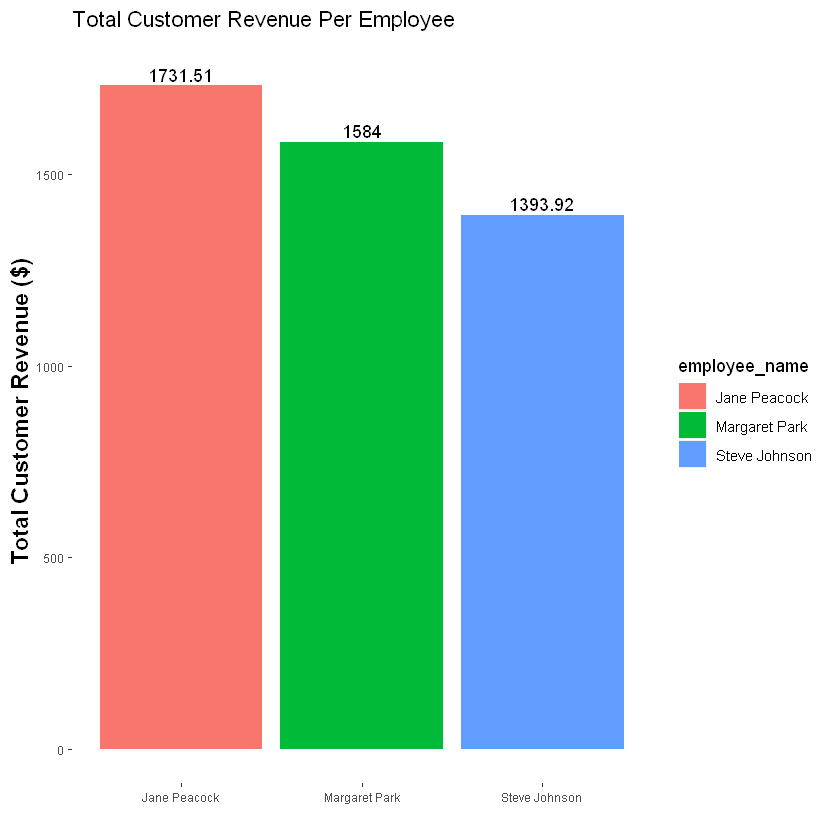

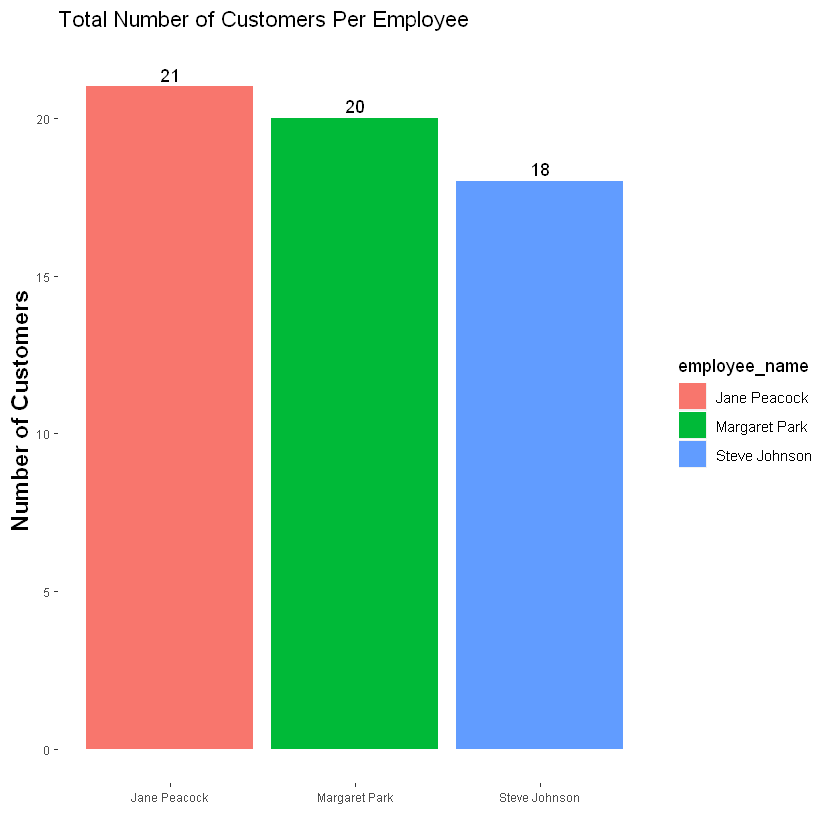

In [9]:
(ggplot(data=employee_performance) 
 + aes(x=employee_name, y = customer_revenue, fill=employee_name) 
 + geom_bar(stat="identity") + labs(title="Total Customer Revenue Per Employee", x ="", y = "Total Customer Revenue ($)")
 + theme(axis.text=element_text(size=7),
        axis.title=element_text(size=14,face="bold"), panel.background = element_rect(fill="white")) 
 + geom_text(aes(employee_name, customer_revenue + 30, label = round(customer_revenue, 2) , fill = NULL), data = employee_performance))

(ggplot(data=employee_performance) 
 + aes(x=employee_name, y = Num_of_Customers, fill=employee_name) 
 + geom_bar(stat="identity") + labs(title="Total Number of Customers Per Employee", x = "", y = "Number of Customers")
 + theme(axis.text=element_text(size=7),
        axis.title=element_text(size=14,face="bold"), panel.background = element_rect(fill="white")) 
 + geom_text(aes(employee_name, Num_of_Customers + 0.4, label = Num_of_Customers , fill = NULL), data = employee_performance))

We see that Jane Peacock has generated the most customer revenue. However, looking at the `hire_date` column, we also see that she was in the company the longest. This also possibly explains why Steve Johnson, the most recent employee, has the fewest customers. 

Jane Peacock has about the same number of customers than Margaret Park, who joined about 1 month after her. **However, the fact that Jane Peacock's customers generated more revenue might mean that her customers might be more willing to make more and bigger purchases.**

As such we'll instead look at the `Revenue_per_customer` table now to compare the employees.

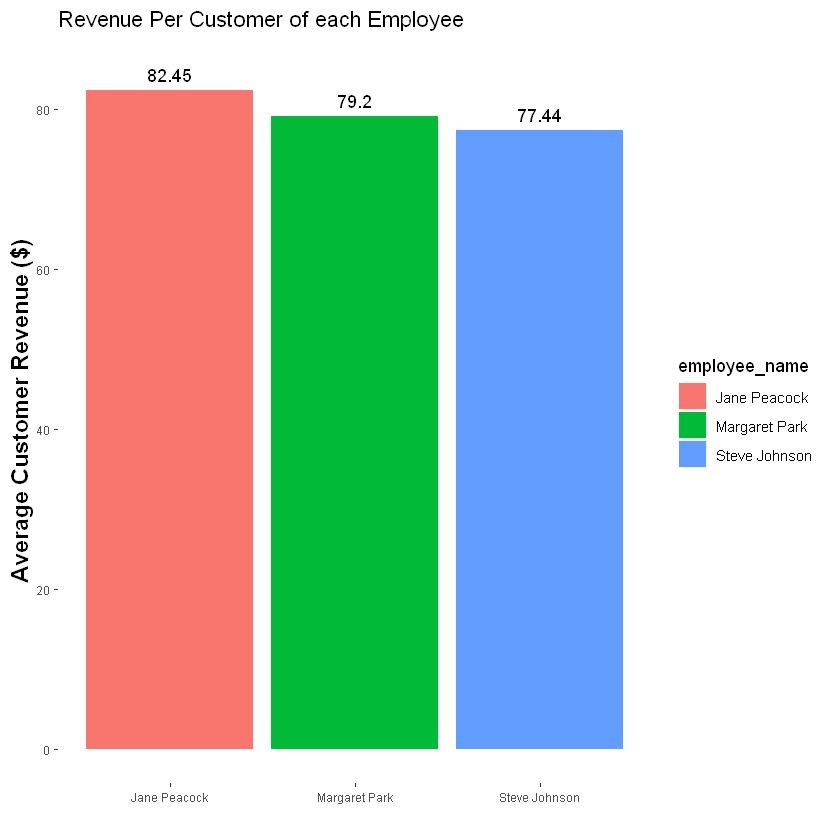

In [10]:
(ggplot(data=employee_performance) 
 + aes(x=reorder(employee_name, -Revenue_per_customer), y = Revenue_per_customer, fill=employee_name) 
 + geom_bar(stat="identity") + labs(title="Revenue Per Customer of each Employee", x="", y ="Average Customer Revenue ($)")
 + theme(axis.text=element_text(size=7),
        axis.title=element_text(size=14,face="bold"), panel.background = element_rect(fill="white")) 
 + geom_text(aes(employee_name, Revenue_per_customer + 2, label = round(Revenue_per_customer, 2) , fill = NULL), data = employee_performance))

We see that Steve Johnson, despite having joined over 5 months after Margaret Park, has a similar figure for 'Revenue per Customer' as her. 

Jane Peacock generates about 5% more 'Revenue per Customer' than either Margaret Park or Steve Johnson. This is very likely due to her experience as the oldest employee. 

Given that the performance of each employee using the 'Revenue per Customer' metric is within 4-5% of each other, it can't be said that any one of them is particularly underperforming or overperforming. Jane Peacock seems to have the best performance in most of our above metrics but that can largely be accounted for by her being the most senior employee. 

## Analyzing Customer Sales Data by Country

Our next task is to analyze the sales data for customers from each different country. We have been advised to use the country value from the customers table, and ignore the country from the billing address in the invoice table.

In particular, we have been directed to calculate data, for each country, in the following metrics:

- Total number of customers
- Total value of sales
- Average value of sales per customer
- Average order value

There are a number of countries with only 1 customers. We'll ignore these Countries.

We'll start this by creating the following condensed view, from which we'll draw the necessary data:

In [11]:
customer_data = "
CREATE VIEW customer_info AS
SELECT 
    c.customer_id,
    c.country,
    i.invoice_id,
    i.total,
    il.track_id
FROM customer c
LEFT JOIN invoice i on i.customer_id = c.customer_id 
LEFT JOIN invoice_line il on il.invoice_id = i.invoice_id
"

run_query(customer_data)

run_query("SELECT * FROM customer_info
LIMIT 10")

Warning message in result_fetch(res@ptr, n = n):
"Don't need to call dbFetch() for statements, only for queries"

<0 x 0 matrix>

customer_id,country,invoice_id,total,track_id
1,Brazil,16,8.91,2160
1,Brazil,16,8.91,875
1,Brazil,16,8.91,83
1,Brazil,16,8.91,16
1,Brazil,16,8.91,1756
1,Brazil,16,8.91,3460
1,Brazil,16,8.91,93
1,Brazil,16,8.91,24
1,Brazil,16,8.91,21
1,Brazil,77,5.94,15


In [12]:
query_cust = "
SELECT 
    ci.country, 
    COUNT(DISTINCT(ci.customer_id)) num_customers,
    SUM(ci.total) total_sales,
    COUNT(DISTINCT(ci.invoice_id)) num_tracks,
    SUM(ci.total) / COUNT(DISTINCT(ci.customer_id)) sales_per_cust,
    SUM(ci.total) / COUNT(DISTINCT(ci.invoice_id)) avg_order_value
    
    
FROM customer_info ci
GROUP BY country
HAVING COUNT(DISTINCT(ci.customer_id)) > 1
ORDER BY 2 DESC

"

country_metrics <- run_query(query_cust)

country_metrics

country,num_customers,total_sales,num_tracks,sales_per_cust,avg_order_value
USA,13,10405.89,131,800.4531,79.43427
Canada,8,5489.55,76,686.1938,72.23092
Brazil,5,4059.00,61,811.8000,66.54098
France,5,3972.87,50,794.5740,79.45740
Germany,4,3441.24,41,860.3100,83.93268
United Kingdom,3,2498.76,28,832.9200,89.24143
Czech Republic,2,3183.84,30,1591.9200,106.12800
India,2,1887.93,21,943.9650,89.90143
Portugal,2,1755.27,29,877.6350,60.52655


The `country_metrics` table above contains all the info necessary to begin visualizing the various metrics.

### Visualizing Data by Country

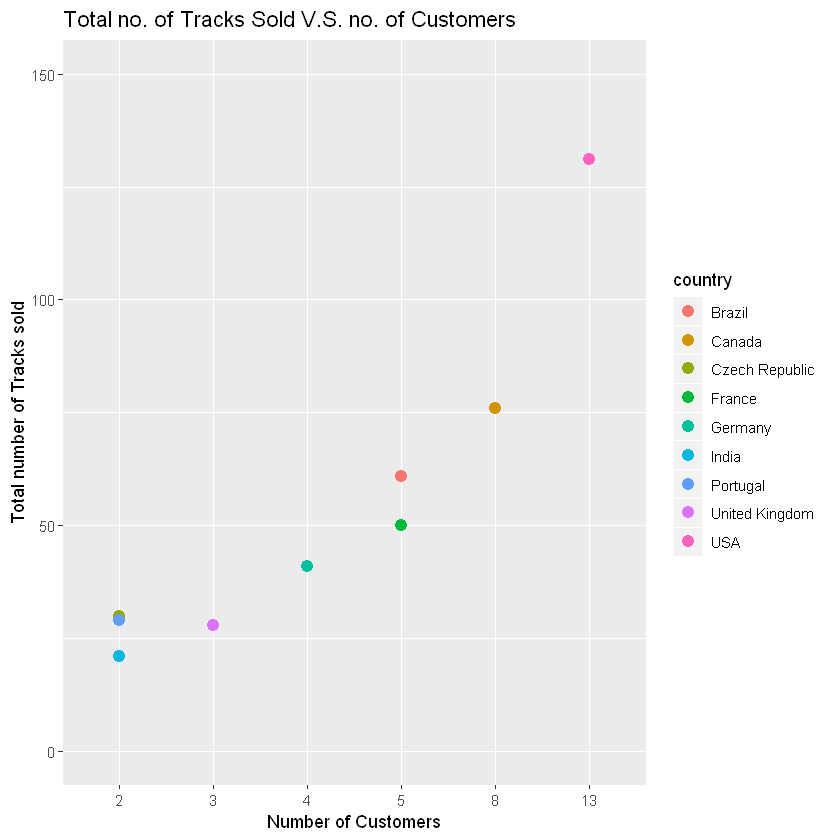

In [13]:
ggplot(data = country_metrics, aes(x = reorder(num_customers, num_tracks),
                                   y = num_tracks, 
                                   color = country)) +
  geom_point(size=3) +
  labs(
    title = "Total no. of Tracks Sold V.S. no. of Customers",
    x = "Number of Customers",
    y = "Total number of Tracks sold"
  ) + ylim(0,150) 

For the most part, we notice that there is a somewhat linear increase in the total Number of Customers in a country, and the resulting total number of tracks sold.

**USA and Canada are our clear biggest markets, in terms of Number of Customers and Total no. of tracks sold.** This is especially true of the USA. These two countries might be particularly good markets to continue focusing on due to the large existing clientele present here. 

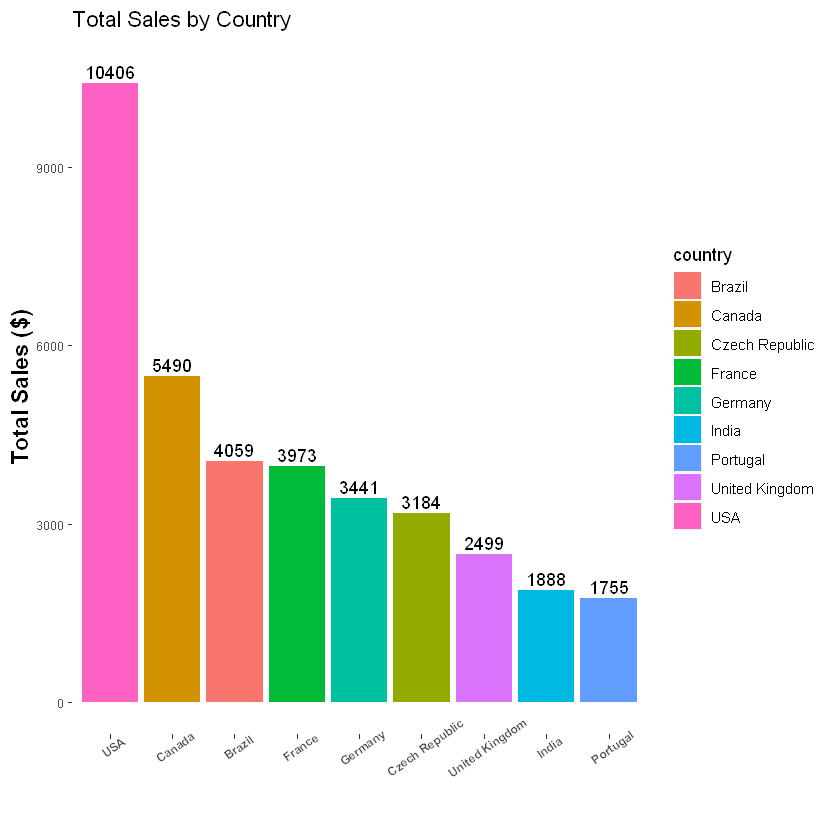

In [14]:
(ggplot(data=country_metrics) + aes(x=reorder(country, -total_sales), y = total_sales, fill=country) 
 + geom_bar(stat="identity") + labs(title="Total Sales by Country", x="", y ="Total Sales ($)")
 + theme(axis.text=element_text(size=7),
        axis.title=element_text(size=14,face="bold"), 
        panel.background = element_rect(fill="white"),
        axis.text.x = element_text(angle = 35, face="bold")) 
 + geom_text(aes(country, total_sales + 200, label = round(total_sales) , fill = NULL), data = country_metrics))


The total sales graph above tells us a similar story as the first graph. Our current biggest market is the USA by a margin, followed by Canada, with Brazil and France closely behind.

Let's investigate some of the smaller markets a little more closely however. 

We'll look at graphs that plot `sales_per_cust` and `avg_order_value` by country, to get a more in-depth look into countries where the market might be smaller.

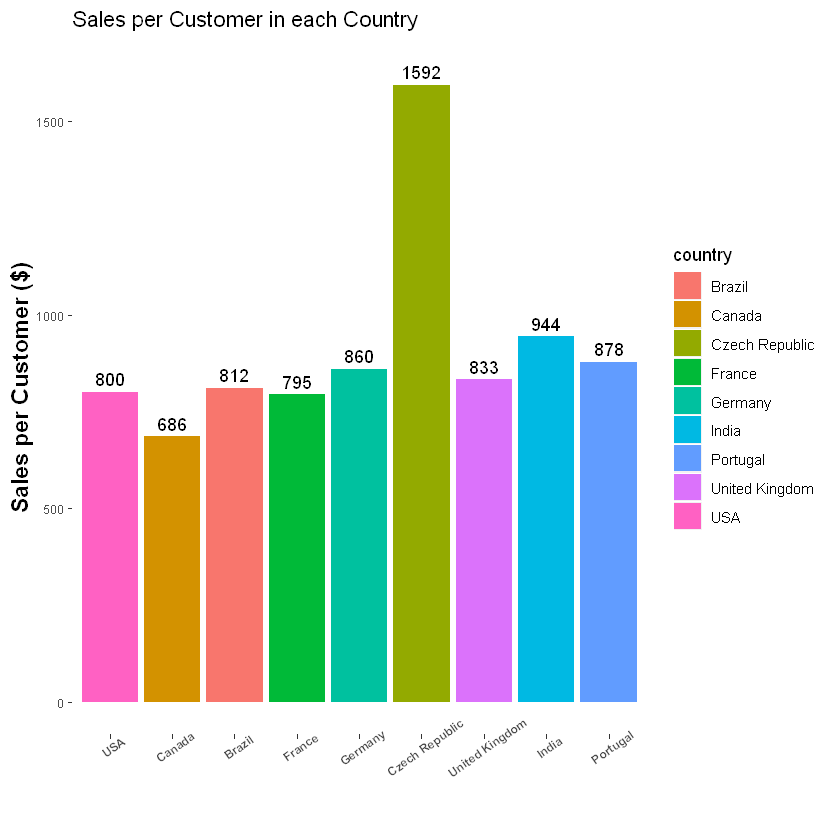

In [15]:
(ggplot(data=country_metrics) + aes(x=reorder(country, -total_sales), y = sales_per_cust, fill=country) 
 + geom_bar(stat="identity") + labs(title="Sales per Customer in each Country", x="", y ="Sales per Customer ($)")
 + theme(axis.text=element_text(size=7),
        axis.title=element_text(size=14,face="bold"), 
        panel.background = element_rect(fill="white"),
        axis.text.x = element_text(angle = 35, face="bold")) 
 + geom_text(aes(country, sales_per_cust + 35, label = round(sales_per_cust) , fill = NULL), data = country_metrics))

**We notice immediately that despite its smaller representation in 'Total Sales', the Czech Republic has an incredibly high 'Sales Per Customer' figure**. This is substantially higher than the figure for other countries, which hover on average in the $800-900 range. 

This could potentially be a smaller market worth making more serious efforts to expand into.

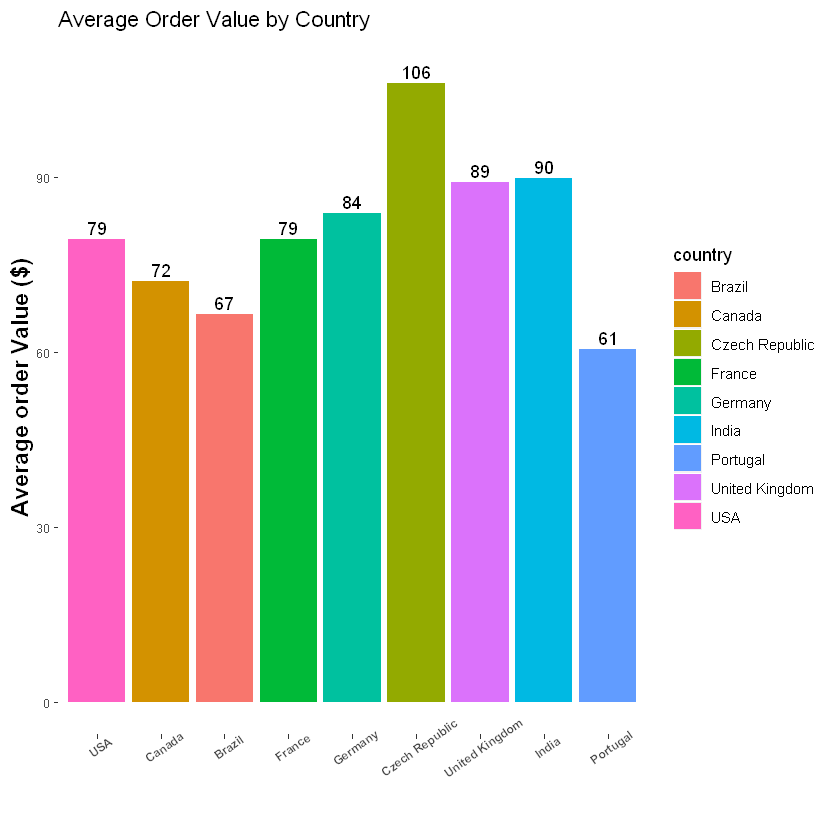

In [16]:
(ggplot(data=country_metrics) + aes(x=reorder(country, -total_sales), y = avg_order_value, fill=country) 
 + geom_bar(stat="identity") + labs(title="Average Order Value by Country", x="", y ="Average order Value ($)")
 + theme(axis.text=element_text(size=7),
        axis.title=element_text(size=14,face="bold"), 
        panel.background = element_rect(fill="white"),
        axis.text.x = element_text(angle = 35, face="bold")) 
 + geom_text(aes(country, avg_order_value + 2, label = round(avg_order_value) , fill = NULL), data = country_metrics))

Again, we observe the Czech Republic has an 'Average Order Value' figure that is 10-20% higher than that of the other markets. It is clear that the Czech Republic holds a lot of promise for potential expansion. The next two highest 'Average Order Value' figures belong to India and the United Kingdom respectively, although considering that these markets make up a fairly small portion of the total revenue, they might not be as good to focus on. 

**The safest approach would be to continue maintaining and satisfying the existing clientele present in countries like USA, Canada, and Brazil, since the majority of the business' revenue comes from these countries, while at the same time making an effort to focus on one smaller market at a time that displays immense potential for growth (like the Czech Republic).** Focusing on too many smaller markets at once might be counter-productive because it could detract from how well the clientele in the larger markets is served.

## Analyzing Customer Purchase Behaviors - Individual Tracks vs Albums

The Chinook store is set up so that customers can make purchases in one of two ways:
1. Purchase a whole album
2. Purchase a collection of one or more individual tracks

The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums, they are charged the same price as if they had purchased each of those tracks separately.

The management is currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks versus whole albums. Management can use this data to understand the effect this decision might have on overall revenue.

In constructing a database query to answer this question, it might be good to be mindful of the possibility of the following 2 customer behaviours: 
1. Albums that have only one or two tracks are likely to be purchased by customers as part of a collection of individual tracks.
2. Customers may decide to manually select every track from an album, and then add a few individual tracks from other albums to their purchase.

Fortunately, the above 2 considerations don't make our job much harder. In the first case, since our analysis is concerned with maximizing revenue, we can safely ignore albums consisting of only a few tracks. The company has previously done analysis to confirm that the second case does not happen often, so we can also ignore this case.

### Writing the Query
The core aspect to the analysis should therefore be identifying if an invoice contains all the tracks from an album. We can do this by getting the list of tracks from an invoice and comparing it to the list of tracks from an album.

We will write a query that categorizes each invoice as either an album purchase or otherwise, and calculates the following summary statistics:

- Number of invoices
- Percentage of invoices


In [58]:
albums_tracks = '
WITH invoice_track AS
    (
     SELECT
         invoice_id invoice_id,
         MIN(track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )
SELECT
    album_purchase,
    COUNT(sub.invoice_id) num_invoices,
    ROUND(CAST(count(sub.invoice_id) AS FLOAT) *100 / (SELECT COUNT(*) FROM invoice), 2) || "%" Percent
    -- SUM(i.total) relative_revenue

FROM
    (
    SELECT
        it.*,
        CASE
        WHEN
             (
              SELECT 
                t.track_id FROM track t
              WHERE t.album_id = (
                                  SELECT 
                                    t2.album_id FROM track t2
                                  WHERE t2.track_id = it.first_track_id)
              EXCEPT 
                  SELECT il2.track_id 
              FROM invoice_line il2
              WHERE il2.invoice_id = it.invoice_id
             ) IS NULL
         AND
             (
              SELECT 
                il2.track_id FROM invoice_line il2
              WHERE il2.invoice_id = it.invoice_id
              EXCEPT 
              SELECT  
                t.track_id FROM track t
              WHERE t.album_id = (
                                  SELECT 
                                    t2.album_id FROM track t2
                                  WHERE t2.track_id = it.first_track_id)
             ) IS NULL
         THEN "Album"
         ELSE "Not Album"
         END as "album_purchase"
     FROM invoice_track it
    ) sub

LEFT JOIN invoice as i ON i.invoice_id = sub.invoice_id
GROUP BY album_purchase

'
run_query(albums_tracks)

album_purchase,num_invoices,Percent
Album,114,18.57%
Not Album,500,81.43%


**With nearly 20% of all sales, and 1/3rd of revenue entirely coming from albums, it would likely be very inadvisable to alter the sales strategy** to emphasize individual tracks from albums, over entire albums.